## Part I: Data Pre-processing

In [2]:
import pandas as pd

In [3]:
# Download the Google Analogy dataset
# !wget http://download.tensorflow.org/data/questions-words.txt

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [6]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [7]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
sub_categories = []
semantic_count = 0
categories = []

for line in data:
    ##########這裡原本只用startwith會出現'list' object has no attribute 'startswith'，詢問chatgpt後得知要加上isinstance判斷是否為str##########
    if isinstance(line, str) and line.startswith(": "): 
        sub_category = line[1:].strip()
        semantic_count += 1
        if semantic_count <= 5:
            category = "Semantic"
        else:
            category = "Syntactic"
    elif isinstance(line, str):  
        questions.append(line)  
        categories.append(category)  
        sub_categories.append(": "+sub_category)

In [8]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [9]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


In [10]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [11]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [12]:
data = pd.read_csv("questions-words.csv")

In [13]:
MODEL_NAME = "glove-twitter-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 387.1/387.1MB downloaded
The Gensim model loaded successfully!


In [14]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split()
      words_a, words_b, words_c, words_d = words
      if all(word in model for word in [words_a, words_b, words_c]):
            predicted_word = model.most_similar(positive=[words_b, words_c], negative=[words_a], topn=1)[0][0]
            preds.append(predicted_word)  
            golds.append(words_d) 
      else:
            preds.append(None)  
            golds.append(None)
      



100%|██████████| 19544/19544 [03:13<00:00, 100.96it/s] 


In [ ]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 97.73367910700192%
Category: Syntactic, Accuracy: 56.91803278688524%
Sub-Category: capital-common-countries, Accuracy: 100.0%
Sub-Category: capital-world, Accuracy: 100.0%
Sub-Category: currency, Accuracy: 100.0%
Sub-Category: city-in-state, Accuracy: 100.0%
Sub-Category: family, Accuracy: 60.27667984189723%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 7.560483870967742%
Sub-Category: gram2-opposite, Accuracy: 20.320197044334975%
Sub-Category: gram3-comparative, Accuracy: 62.53753753753754%
Sub-Category: gram4-superlative, Accuracy: 57.48663101604278%
Sub-Category: gram5-present-participle, Accuracy: 61.17424242424242%
Sub-Category: gram6-nationality-adjective, Accuracy: 100.0%
Sub-Category: gram7-past-tense, Accuracy: 49.42307692307693%
Sub-Category: gram8-plural, Accuracy: 65.39039039039038%
Sub-Category: gram9-plural-verbs, Accuracy: 54.137931034482754%


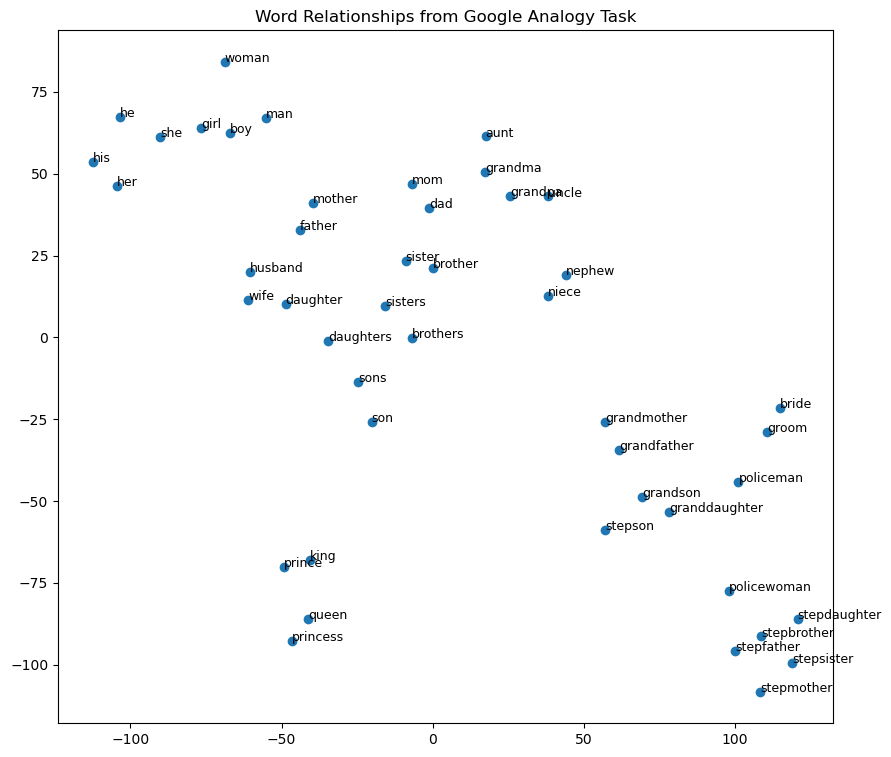

<Figure size 640x480 with 0 Axes>

In [16]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"


#參考資料：https://vocus.cc/article/6471799dfd89780001604a5b

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
data_family = data[data["SubCategory"]==SUB_CATEGORY]
words = data_family["Question"].values
words = list(set(" ".join(words).split()))
word_vectors_family = np.array([model[word] for word in words])

tsne = TSNE(n_components=2,perplexity=5,random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors_family)


plt.figure(figsize=(10, 9))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

#詢問chatgpt如何將文字標籤加入圖中
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=9)

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [17]:
# # Download the split Wikipedia files
# # Each file contain 562365 lines (articles).
# !gdown --id 1J0os1846PQ129t720aI0wMm-5GepEwSl -O wiki_texts_part_0.txt.gz
# !gdown --id 1tsI3RSKPN3b2-1IZ0N7bmjgVRf-THIkW -O wiki_texts_part_1.txt.gz
# !gdown --id 1koiw6RFNzDe6pe2zMTfVhsEKmpmnYyu5 -O wiki_texts_part_2.txt.gz
# !gdown --id 1YSGbDqhbg2xJsWD_hYQ5z9URl0dCTC2m -O wiki_texts_part_3.txt.gz
# !gdown --id 1PA3C99C8CcLFjkenT0a9iU07XEQmXyG_ -O wiki_texts_part_4.txt.gz

In [18]:
# !gdown --id 1sSLea4hq6Z7oT6noOU_II1ahWjNOKcDX -O wiki_texts_part_5.txt.gz
# !gdown --id 1i6kXTDtZkRiivJ0mj-5GkVbE4gMFlmSb -O wiki_texts_part_6.txt.gz
# !gdown --id 1ain2DN1nxXfsmJ2Aj9TFZlLVJSPsu9Jb -O wiki_texts_part_7.txt.gz
# !gdown --id 1UKhvielQDqQz5pMZ7J3SHv9m8_8gO-dE -O wiki_texts_part_8.txt.gz
# !gdown --id 1q1zMA4hbMS7tID2GTQx-c94UPB8YQaaa -O wiki_texts_part_9.txt.gz
# !gdown --id 1-kkGxwMxPsoGg5_2pdaOeE3Way6njLpH -O wiki_texts_part_10.txt.gz

In [19]:
# # Extract the downloaded wiki_texts_parts files.
# !gunzip -k wiki_texts_part_*.gz

In [20]:
# # Combine the extracted wiki_texts_parts files.
# !cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [21]:
# # Check the first ten lines of the combined file
# !head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [22]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
output_path = "wiki_texts_20_sampled.txt"
with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
        wiki_texts = f.readlines()  
        sample_size = int(len(wiki_texts) * 0.2) 
        sampled_texts = random.sample(wiki_texts, sample_size)  
        output_file.writelines(sampled_texts)  

In [23]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
import re
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm  
# 詢問chatgpt：如果我要把txt資料集中不是英文詞語都去除要怎麼做？ 以下為chatgpt給出的回覆：定義正則表達式：只保留英文字母和空格
pattern = re.compile(r'[^a-zA-Z\s]')

file_path = 'wiki_texts_20_sampled.txt'
cleaned_lines = []
 
with open(file_path, 'r', encoding='utf-8') as infile:
    for line in infile:
        # 使用正則表達式過濾非英文字母字符
        cleaned_line = re.sub(pattern, '', line)
        # 將處理後的行存入list
        cleaned_lines.append(cleaned_line)

#remove stop words 參考資料：https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
new_cleaned_lines = [remove_stopwords(line) for line in cleaned_lines]

nltk.download('punkt')

tokens = []
###因檔案太大，請chatgpt幫我加入進度條
# for line in tqdm(new_cleaned_lines, desc="Processing lines"):  # 加入進度條
#     tokens.extend(word_tokenize(line.lower()))

# word_freq = Counter(tokens)
# most_common_words = [word for word, freq in word_freq.most_common(1000)]
# filtered_tokens = [word for word in tokens if word in most_common_words]
# filtered_text = ' '.join(filtered_tokens)
# print(filtered_text[:10])



[nltk_data] Downloading package punkt to /home/ccching/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
# sentences = [word_tokenize(sent) for line in new_cleaned_lines for sent in sent_tokenize(line)]

# sentences = [word_tokenize(sent) for sent in sent_tokenize(new_cleaned_lines )]

sentences = [word_tokenize(sent) for line in tqdm(new_cleaned_lines) for sent in sent_tokenize(line)]

# 訓練 Word2Vec 模型
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=6)

# 保存模型
model.save("word2vec.model")

# 顯示相似詞
print(model.wv.most_similar("new"))


100%|██████████| 1124731/1124731 [22:28<00:00, 833.81it/s] 


[('tripmen', 0.6249803304672241), ('lyndhursts', 0.6140738725662231), ('yorkjim', 0.6103036403656006), ('current', 0.5856621265411377), ('louisianaapril', 0.580233633518219), ('newest', 0.5784385204315186), ('islamberg', 0.573934018611908), ('yorkpride', 0.5672963261604309), ('minxters', 0.5667341947555542), ('future', 0.5614201426506042)]


In [27]:
data = pd.read_csv("questions-words.csv")

In [30]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split()
      words_a, words_b, words_c, words_d = words
      if all(word in model.wv for word in [words_a, words_b, words_c]):
            predicted_word = model.wv.most_similar(positive=[words_b, words_c], negative=[words_a], topn=1)[0][0]
            preds.append(predicted_word)  
            golds.append(words_d) 
      else:
            preds.append(None)  
            golds.append(None)

  0%|          | 0/19544 [00:00<?, ?it/s]

100%|██████████| 19544/19544 [14:12<00:00, 22.92it/s]  


In [35]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 99.09798173413012%
Category: Syntactic, Accuracy: 60.37470725995316%
Sub-Category: capital-common-countries, Accuracy: 100.0%
Sub-Category: capital-world, Accuracy: 100.0%
Sub-Category: currency, Accuracy: 100.0%
Sub-Category: city-in-state, Accuracy: 100.0%
Sub-Category: family, Accuracy: 84.18972332015811%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 35.58467741935484%
Sub-Category: gram2-opposite, Accuracy: 15.147783251231528%
Sub-Category: gram3-comparative, Accuracy: 68.31831831831832%
Sub-Category: gram4-superlative, Accuracy: 38.50267379679144%
Sub-Category: gram5-present-participle, Accuracy: 64.39393939393939%
Sub-Category: gram6-nationality-adjective, Accuracy: 100.0%
Sub-Category: gram7-past-tense, Accuracy: 57.56410256410256%
Sub-Category: gram8-plural, Accuracy: 67.71771771771772%
Sub-Category: gram9-plural-verbs, Accuracy: 62.98850574712643%


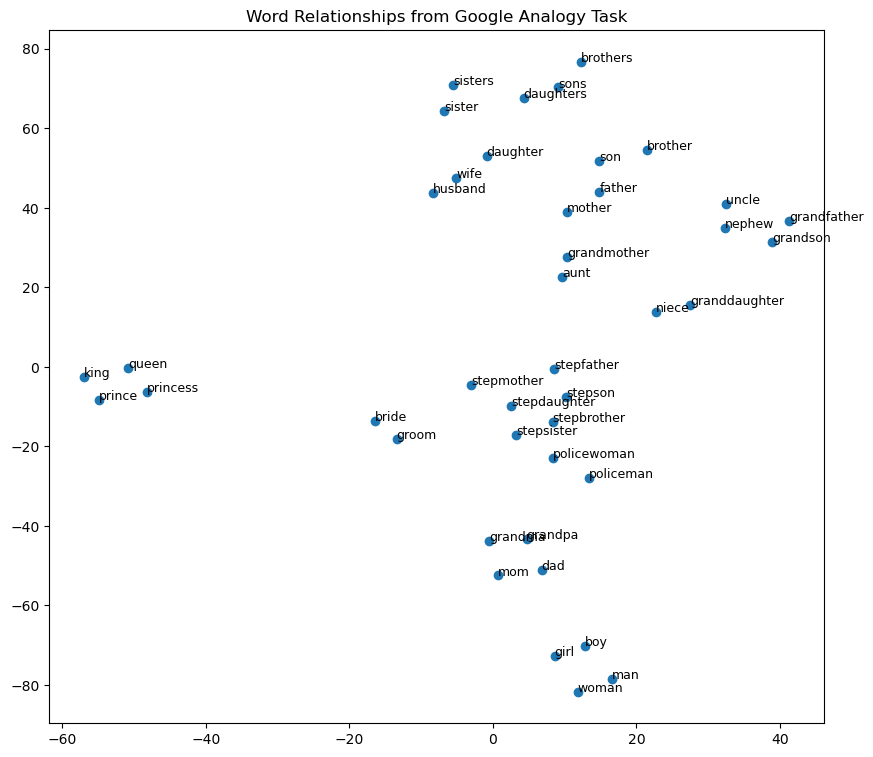

<Figure size 640x480 with 0 Axes>

In [36]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# 選擇 family 類別的詞
data_family = data[data["SubCategory"] == SUB_CATEGORY]
questions = data_family["Question"].values
words = list(set(" ".join(questions).split()))

# 只保留在詞向量模型中出現的詞
valid_words = [word for word in words if word in model.wv]
word_vectors_family = np.array([model.wv[word] for word in valid_words])

# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors_family)

# 繪圖
plt.figure(figsize=(10, 9))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# 確保 valid_words 與 word_vectors_2d 尺寸相符
for i, word in enumerate(valid_words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=9)

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")
